<a href="https://colab.research.google.com/github/santosh199518/Facial-Expression-Recognition/blob/main/Facial_Emotion_Recogination.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Facial Emotion Recogination

## importing libraries

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from keras import regularizers
from keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, EarlyStopping, ReduceLROnPlateau
import datetime
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from zipfile import ZipFile
import os

#Connecting to google drive to insert dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Copying dataset to current directory

In [4]:
!ls "/content/drive/My Drive/Facial Emotion Recognition"
!cp "/content/drive/My Drive/Facial Emotion Recognition/archive.zip" "archive.zip"


archive.zip


#Extracting zipped dataset

In [5]:
file_name = "archive.zip"
with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


## Importing Dataset

In [6]:
train_dir = 'train/'
test_dir = 'test/'

row, col = 48, 48
classes = 7

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')
print(train_count)
print(test_count)

       fear  surprise  angry   sad  happy  disgust  neutral
train  4097      3171   3995  4830   7215      436     4965
      fear  surprise  angry   sad  happy  disgust  neutral
test  1024       831    958  1247   1774      111     1233


### PLot of number of images in training set

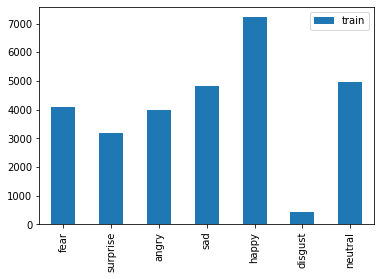

In [7]:
train_count.transpose().plot(kind='bar')

### PLot of number of images in test set

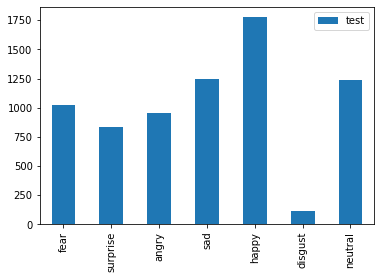

In [8]:
test_count.transpose().plot(kind='bar')

#Plotting first images of exery emotions

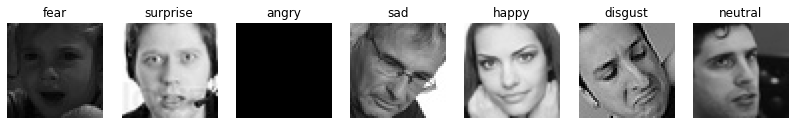

In [9]:
plt.figure(figsize=(14,22))
i = 1
for expression in os.listdir(train_dir):
    img = load_img((train_dir + expression +'/'+ os.listdir(train_dir + expression)[1]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show()

## Creating Training and test sets

In [10]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   zoom_range=0.3,
                                   horizontal_flip=True)

training_set = train_datagen.flow_from_directory(train_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(test_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [11]:
training_set.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

## Defining Model

In [12]:
def get_model(input_size, classes=7):
     #Initialising the CNN
    model = tf.keras.models.Sequential()   

    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape =input_size))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(classes, activation='softmax'))

    #Compliling the model
    model.compile(optimizer=Adam(lr=0.0001, decay=1e-6), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

In [13]:
my_model = get_model((row,col,1), classes)
my_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       7

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


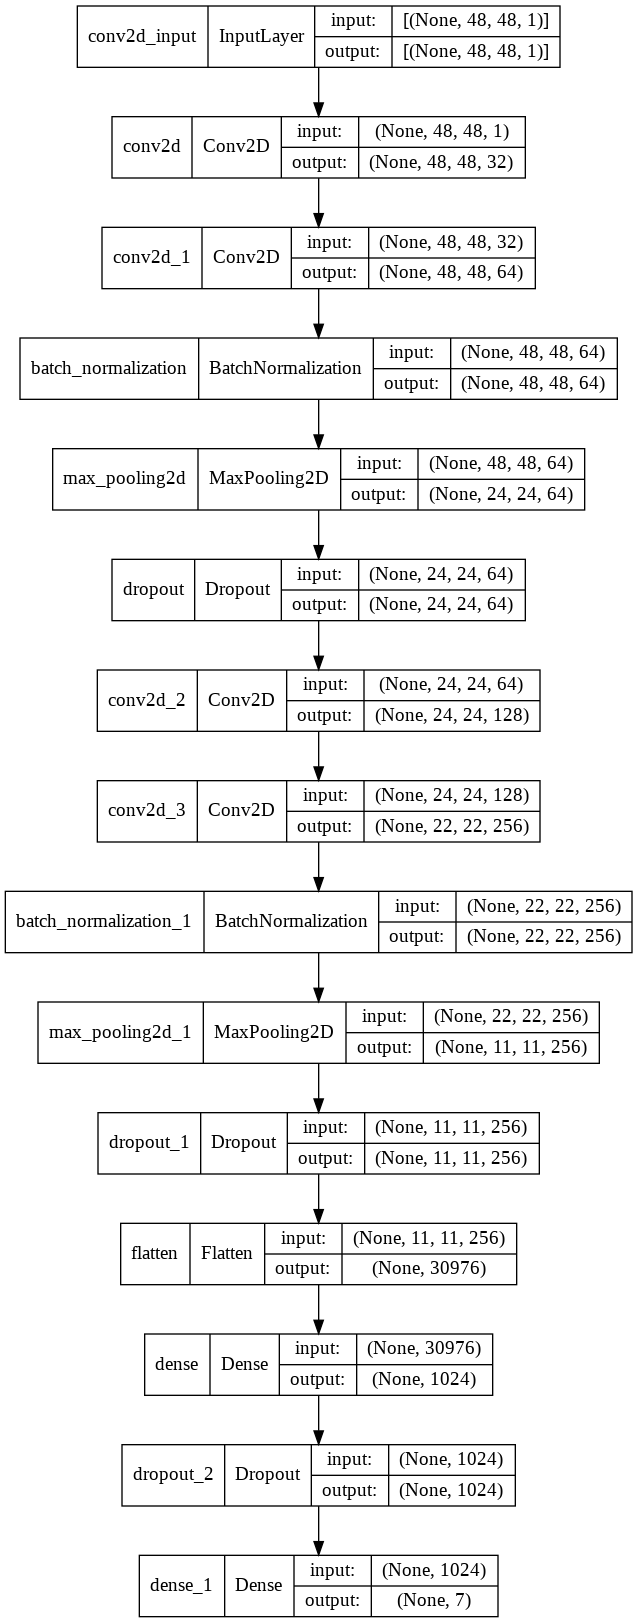

In [14]:
plot_model(my_model, to_file='my_model.png', show_shapes=True, show_layer_names=True)

### Callbacks Function

In [15]:
chk_path = 'my_model.h5'
log_dir = "checkpoint/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             moniter='val_loss')

earlystop = EarlyStopping(monitor='val_loss', 
                          min_delta=0, 
                          patience=3, 
                          verbose=1, 
                          restore_best_weights=True)
                        
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=6, 
                              verbose=1, 
                              min_delta=0.0001)


tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
csv_logger = CSVLogger('training.log')

callbacks = [checkpoint, reduce_lr, csv_logger]

## Training Model

In [16]:
steps_per_epoch = training_set.n // training_set.batch_size
validation_steps = test_set.n // test_set.batch_size

hist = my_model.fit(x=training_set,
                 validation_data=test_set,
                 epochs=60,
                 callbacks=callbacks,
                 steps_per_epoch=steps_per_epoch,
                 validation_steps=validation_steps)

Epoch 1/60
448/448 [==============================] - ETA: 0s - loss: 4.3175 - accuracy: 0.2767
Epoch 00001: val_loss improved from inf to 8.79417, saving model to my_model.h5
448/448 [==============================] - 70s 87ms/step - loss: 4.3175 - accuracy: 0.2767 - val_loss: 8.7942 - val_accuracy: 0.0266 - lr: 1.0000e-04
Epoch 2/60
448/448 [==============================] - ETA: 0s - loss: 3.5479 - accuracy: 0.3317
Epoch 00002: val_loss improved from 8.79417 to 3.17997, saving model to my_model.h5
448/448 [==============================] - 38s 84ms/step - loss: 3.5479 - accuracy: 0.3317 - val_loss: 3.1800 - val_accuracy: 0.4016 - lr: 1.0000e-04
Epoch 3/60
448/448 [==============================] - ETA: 0s - loss: 3.0273 - accuracy: 0.3669
Epoch 00003: val_loss improved from 3.17997 to 2.68067, saving model to my_model.h5
448/448 [==============================] - 38s 84ms/step - loss: 3.0273 - accuracy: 0.3669 - val_loss: 2.6807 - val_accuracy: 0.4389 - lr: 1.0000e-04
Epoch 4/60
448

## Loss and Accuracy plot

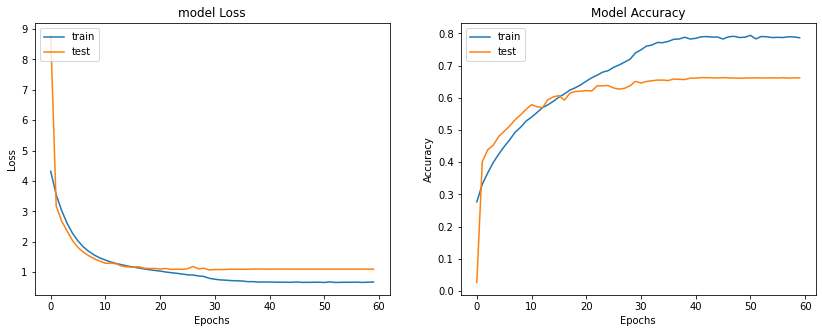

In [17]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

high accracy is achieved on training set but accuracy on validation set is stuck at 66% also no overfitting can be seen in the dataset hence is can be concluded that the inefficiency may be due to the unbalanced dataset

### Model evaluation

In [18]:
train_loss, train_accu = my_model.evaluate(training_set)
test_loss, test_accu = my_model.evaluate(test_set)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

113/113 [==============================] - 4s 31ms/step - loss: 1.0993 - accuracy: 0.6617
final train accuracy = 86.22 , validation accuracy = 66.17


In [19]:
my_model.save_weights('my_model_bestweight.h5')

### Confusion Matrix and Classification on training set

Confusion Matrix
[[ 558   49  515 1019  742  655  457]
 [  49    5   62  141   78   63   38]
 [ 543   50  499 1075  756  718  456]
 [ 966   93  937 1877 1329 1219  794]
 [ 728   64  651 1235  871  896  520]
 [ 624   51  582 1270  895  837  571]
 [ 425   56  408  825  566  540  351]]
Classification Report
              precision    recall  f1-score   support

       angry       0.14      0.14      0.14      3995
     disgust       0.01      0.01      0.01       436
        fear       0.14      0.12      0.13      4097
       happy       0.25      0.26      0.26      7215
     neutral       0.17      0.18      0.17      4965
         sad       0.17      0.17      0.17      4830
    surprise       0.11      0.11      0.11      3171

    accuracy                           0.17     28709
   macro avg       0.14      0.14      0.14     28709
weighted avg       0.17      0.17      0.17     28709



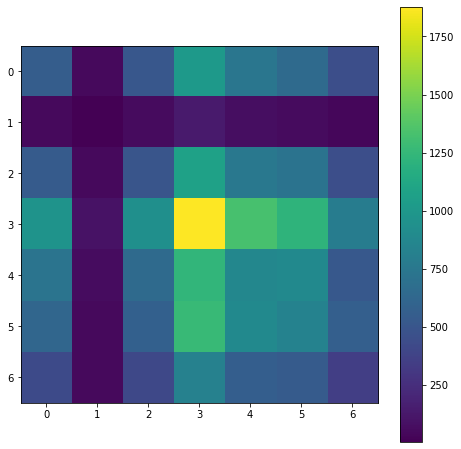

In [20]:
y_pred = my_model.predict(training_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

from sklearn.metrics import classification_report, confusion_matrix
cm_train = confusion_matrix(training_set.classes, y_pred)
print('Confusion Matrix')
print(cm_train)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(training_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
# tick_mark = np.arange(len(target_names))
# _ = plt.xticks(tick_mark, target_names, rotation=90)
# _ = plt.yticks(tick_mark, target_names)

### Confusion Matrix and Classification on test set

Confusion Matrix
[[132   8 121 229 181 178 109]
 [ 21   1   8  32  18  13  18]
 [172   4  98 255 178 198 119]
 [226  14 229 450 344 302 209]
 [169  17 139 307 246 211 144]
 [169  13 149 336 251 194 135]
 [111   9  91 196 168 164  92]]
Classification Report
              precision    recall  f1-score   support

       angry       0.13      0.14      0.13       958
     disgust       0.02      0.01      0.01       111
        fear       0.12      0.10      0.11      1024
       happy       0.25      0.25      0.25      1774
     neutral       0.18      0.20      0.19      1233
         sad       0.15      0.16      0.15      1247
    surprise       0.11      0.11      0.11       831

    accuracy                           0.17      7178
   macro avg       0.14      0.14      0.14      7178
weighted avg       0.17      0.17      0.17      7178



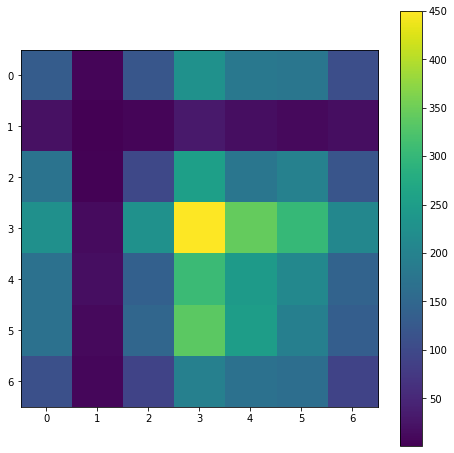

In [21]:
y_pred = my_model.predict(test_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

#from sklearn.metrics import classification_report, confusion_matrix
cm_test = confusion_matrix(test_set.classes, y_pred)
print('Confusion Matrix')
print(cm_test)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(test_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_test, interpolation='nearest')
plt.colorbar()
# tick_mark = np.arange(len(target_names))
# _ = plt.xticks(tick_mark, target_names, rotation=90)
# _ = plt.yticks(tick_mark, target_names)

#To test with other images to find emotions

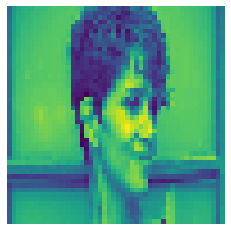

happy


In [44]:
image_path = "images.jpg"
image = load_img(image_path, color_mode='grayscale', target_size=(48,48))
plt.imshow(image)
plt.axis('off')
plt.show()
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr]) 
predictions = my_model.predict(input_arr)

y_pred = np.argmax(predictions, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}
for i in range(len(predictions[0])):
  if predictions[0][i] ==1:
    print(class_labels[i])